<a href="https://colab.research.google.com/github/JumanaRahim/workshop/blob/master/LUNG_NODULE_DETECTION_resnet_152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
!pip install pretrainedmodels
!pip install torchsummary
!pip install imutils
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=ecdf8440c777bdca408e06ef5ea2d5ade7eb4130c09178403124823e54874100
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels
  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=787a46bf5d0059cee2333504e58fee871eadfee312861dbc6c5e329a69db9f97
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [ ]:
import os
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from torchsummary import summary
from torch import nn
import torch.nn.functional as F
from imutils import paths
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import pretrainedmodels
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
root='/kaggle/input/lung-dataset'

In [ ]:
classes=('benign', 'malignant', 'non-nodule')

In [ ]:
image_paths = list(paths.list_images('/kaggle/input/lung-dataset'))

data = []
labels = []
for img_path in image_paths:
    label = img_path.split(os.path.sep)[-2]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    data.append(img)
    labels.append(label)
    
data = np.array(data)
labels = np.array(labels)

In [ ]:
labels

array(['non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-n

In [ ]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
print(f"Total Number of Classes: {len(lb.classes_)}")

Total Number of Classes: 3


In [ ]:
#orginal dataset

train_orginal_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_orginal_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])    


#for data augmentation

train_augmentation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_augmentation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [ ]:
# divide the data into train, validation, and test set
#(X, x_val , Y, y_val) = train_test_split(data, labels, test_size=0.2,  stratify=labels,random_state=42)
#(x_train, x_test, y_train, y_test) = train_test_split(X, Y, test_size=0.25, random_state=42)
#print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

(x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.3,random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}")

x_train examples: (172, 2048, 2048, 3)
x_test examples: (75, 2048, 2048, 3)


In [ ]:
batch_size=6

In [ ]:
# custom dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transforms = None):
        self.labels = labels
        self.images = images
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        data = self.images[index][:]
        labels = self.labels[index]
        
        if self.transforms:
            data = self.transforms(data)
            
            return data,labels

        
        
        
        
train_orginal_data = CustomDataset(x_train, y_train, train_orginal_transforms)
test_orginal_data = CustomDataset(x_test, y_test, test_orginal_transforms)     


train_augmentation_data = CustomDataset(x_train, y_train, train_augmentation_transforms )
test_augmentation_data = CustomDataset(x_test, y_test, test_augmentation_transforms )  

train_data = torch.utils.data.ConcatDataset([train_orginal_data,train_augmentation_data])
print(len(train_data))
test_data = torch.utils.data.ConcatDataset([test_orginal_data,test_augmentation_data])
print(len(test_data))




trainLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
testLoader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4) 

344
150


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for X, y in trainLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([6, 3, 224, 224])
Shape of y: torch.Size([6]) torch.int64


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# **MODEL**

In [ ]:
class resnet152(nn.Module):
    def __init__(self, pretrained):
        super(resnet152, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__['resnet152'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet152'](pretrained = None)
        # change the classification layer
        self.l0= nn.Linear(2048, len(lb.classes_))
        self.dropout = nn.Dropout2d(0.4)
        
    def forward(self, x):
        # get the batch size only, ignore(c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        #x = self.dropout(x)
        l0 = self.l0(x)
        return l0

model = resnet152(pretrained=True).to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

resnet152(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = resnet152(pretrained=True).to(device)

#model.load_state_dict(torch.load("/kaggle/working/model.pth", map_location= device))

model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# **OPTIMZER**

In [ ]:
lr = 0.001

WEIGHT_DECAY = 0.0005
save_path = "model.pth"
fine_tune = True
#load_path = "/kaggle/working/model_1.pth"

In [ ]:
# loss function
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=WEIGHT_DECAY)
optimizer= torch.optim.SGD(model.parameters(),lr= lr,momentum=0.9)

# **LOAD MODEL**

In [ ]:
#state_dict = torch.load(load_path, map_location=device)
#model.load_state_dict(state_dict)

# **TRAINING**

In [ ]:
def train(model,dataloader):    
    # training function

    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    total=0
    for batch, (X, y) in enumerate(tqdm(dataloader)):


        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_correct += (outputs.argmax(1) == y).type(torch.float).sum().item()
        total += y.size(0)

    loss = running_loss/len(dataloader)
    accuracy = 100.*running_correct/total
    print('Train Loss: %.3f | Accuracy: %.3f'%(loss, accuracy))


    #print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")


    return loss, accuracy

# **VALIDATION**

In [ ]:
#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total=0
    with torch.no_grad():
        
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)
            running_loss += loss_fn(pred, y).item()        
            running_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            total += y.size(0)
        
    loss = running_loss/len(dataloader)
    accuracy = 100.*running_correct/total
    #print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}')
    print('Test Loss: %.3f | Accuracy: %.3f'%(loss, accuracy))


    return loss, accuracy

# **TRAINING AND VALIDATION IN SINGLE FUNCTION**

In [ ]:
epochs=50


train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
print(f"Training on {len(train_data)} examples, validating on {len(test_data)} examples...")

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = train(model, trainLoader)
    val_epoch_loss, val_epoch_accuracy = validate(model, testLoader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

Training on 344 examples, validating on 150 examples...
Epoch 1 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.29it/s]

Train Loss: 1.162 | Accuracy: 38.663
Validating


Test Loss: 1.048 | Accuracy: 47.333
Epoch 2 of 50
Training


100%|██████████| 58/58 [00:14<00:00,  4.12it/s]

Train Loss: 1.167 | Accuracy: 43.023
Validating


Test Loss: 1.071 | Accuracy: 42.000
Epoch 3 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.34it/s]

Train Loss: 1.112 | Accuracy: 50.000
Validating


Test Loss: 1.128 | Accuracy: 51.333
Epoch 4 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.27it/s]

Train Loss: 0.945 | Accuracy: 54.070
Validating


Test Loss: 1.435 | Accuracy: 42.000
Epoch 5 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.36it/s]

Train Loss: 0.749 | Accuracy: 65.698
Validating


Test Loss: 1.321 | Accuracy: 57.333
Epoch 6 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.27it/s]

Train Loss: 0.718 | Accuracy: 66.279
Validating


Test Loss: 1.286 | Accuracy: 48.667
Epoch 7 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.16it/s]

Train Loss: 0.664 | Accuracy: 73.547
Validating


Test Loss: 1.251 | Accuracy: 48.667
Epoch 8 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.27it/s]

Train Loss: 0.455 | Accuracy: 81.105
Validating


Test Loss: 1.270 | Accuracy: 54.000
Epoch 9 of 50
Training


100%|██████████| 58/58 [00:14<00:00,  4.06it/s]

Train Loss: 0.516 | Accuracy: 79.360
Validating


Test Loss: 1.720 | Accuracy: 44.667
Epoch 10 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.22it/s]

Train Loss: 0.613 | Accuracy: 77.035
Validating


Test Loss: 1.683 | Accuracy: 50.667
Epoch 11 of 50
Training


100%|██████████| 58/58 [00:14<00:00,  4.10it/s]

Train Loss: 0.564 | Accuracy: 79.070
Validating


Test Loss: 1.513 | Accuracy: 48.667
Epoch 12 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.15it/s]

Train Loss: 0.436 | Accuracy: 81.395
Validating


Test Loss: 1.485 | Accuracy: 52.667
Epoch 13 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.23it/s]

Train Loss: 0.439 | Accuracy: 81.395
Validating


Test Loss: 1.674 | Accuracy: 50.667
Epoch 14 of 50
Training


100%|██████████| 58/58 [00:14<00:00,  4.06it/s]

Train Loss: 0.271 | Accuracy: 89.535
Validating


Test Loss: 1.563 | Accuracy: 48.000
Epoch 15 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.26it/s]

Train Loss: 0.294 | Accuracy: 87.209
Validating


Test Loss: 1.980 | Accuracy: 50.667
Epoch 16 of 50
Training


100%|██████████| 58/58 [00:14<00:00,  3.99it/s]

Train Loss: 0.314 | Accuracy: 87.209
Validating


Test Loss: 2.030 | Accuracy: 45.333
Epoch 17 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.22it/s]

Train Loss: 0.309 | Accuracy: 86.919
Validating


Test Loss: 1.444 | Accuracy: 56.000
Epoch 18 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.34it/s]

Train Loss: 0.223 | Accuracy: 90.698
Validating


Test Loss: 1.631 | Accuracy: 56.667
Epoch 19 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.30it/s]

Train Loss: 0.223 | Accuracy: 91.860
Validating


Test Loss: 1.532 | Accuracy: 56.000
Epoch 20 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.33it/s]

Train Loss: 0.179 | Accuracy: 93.895
Validating


Test Loss: 1.657 | Accuracy: 54.000
Epoch 21 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.17it/s]

Train Loss: 0.221 | Accuracy: 93.314
Validating


Test Loss: 2.053 | Accuracy: 50.667
Epoch 22 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.33it/s]

Train Loss: 0.259 | Accuracy: 92.733
Validating


Test Loss: 1.861 | Accuracy: 52.667
Epoch 23 of 50
Training


100%|██████████| 58/58 [00:14<00:00,  4.10it/s]

Train Loss: 0.383 | Accuracy: 88.663
Validating


Test Loss: 2.417 | Accuracy: 47.333
Epoch 24 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.35it/s]

Train Loss: 0.219 | Accuracy: 94.477
Validating


Test Loss: 1.723 | Accuracy: 52.000
Epoch 25 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.21it/s]

Train Loss: 0.188 | Accuracy: 93.314
Validating


Test Loss: 1.524 | Accuracy: 54.667
Epoch 26 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.27it/s]

Train Loss: 0.183 | Accuracy: 93.023
Validating


Test Loss: 1.682 | Accuracy: 57.333
Epoch 27 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.31it/s]

Train Loss: 0.108 | Accuracy: 96.221
Validating


Test Loss: 1.861 | Accuracy: 49.333
Epoch 28 of 50
Training


100%|██████████| 58/58 [00:14<00:00,  4.13it/s]

Train Loss: 0.115 | Accuracy: 96.802
Validating


Test Loss: 2.067 | Accuracy: 51.333
Epoch 29 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.39it/s]

Train Loss: 0.217 | Accuracy: 95.058
Validating


Test Loss: 1.995 | Accuracy: 50.000
Epoch 30 of 50
Training


100%|██████████| 58/58 [00:14<00:00,  4.10it/s]

Train Loss: 0.248 | Accuracy: 91.860
Validating


Test Loss: 1.569 | Accuracy: 50.667
Epoch 31 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.25it/s]

Train Loss: 0.124 | Accuracy: 95.640
Validating


Test Loss: 2.028 | Accuracy: 52.000
Epoch 32 of 50
Training


100%|██████████| 58/58 [00:14<00:00,  4.10it/s]

Train Loss: 0.116 | Accuracy: 97.384
Validating


Test Loss: 1.841 | Accuracy: 50.000
Epoch 33 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.27it/s]

Train Loss: 0.157 | Accuracy: 95.349
Validating


Test Loss: 2.054 | Accuracy: 52.667
Epoch 34 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.35it/s]

Train Loss: 0.091 | Accuracy: 98.256
Validating


Test Loss: 2.082 | Accuracy: 50.000
Epoch 35 of 50
Training


100%|██████████| 58/58 [00:14<00:00,  4.11it/s]

Train Loss: 0.127 | Accuracy: 95.640
Validating


Test Loss: 2.183 | Accuracy: 52.667
Epoch 36 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.31it/s]

Train Loss: 0.118 | Accuracy: 97.965
Validating


Test Loss: 2.058 | Accuracy: 53.333
Epoch 37 of 50
Training


100%|██████████| 58/58 [00:14<00:00,  4.13it/s]

Train Loss: 0.154 | Accuracy: 96.221
Validating


Test Loss: 1.812 | Accuracy: 49.333
Epoch 38 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.28it/s]

Train Loss: 0.075 | Accuracy: 96.802
Validating


Test Loss: 1.691 | Accuracy: 55.333
Epoch 39 of 50
Training


100%|██████████| 58/58 [00:15<00:00,  3.76it/s]

Train Loss: 0.137 | Accuracy: 96.802
Validating


Test Loss: 2.108 | Accuracy: 51.333
Epoch 40 of 50
Training


100%|██████████| 58/58 [00:14<00:00,  3.94it/s]

Train Loss: 0.129 | Accuracy: 96.221
Validating


Test Loss: 2.026 | Accuracy: 54.000
Epoch 41 of 50
Training


100%|██████████| 58/58 [00:14<00:00,  4.09it/s]

Train Loss: 0.042 | Accuracy: 99.419
Validating


Test Loss: 2.480 | Accuracy: 48.000
Epoch 42 of 50
Training


100%|██████████| 58/58 [00:14<00:00,  4.05it/s]

Train Loss: 0.049 | Accuracy: 97.965
Validating


Test Loss: 2.080 | Accuracy: 54.000
Epoch 43 of 50
Training


100%|██████████| 58/58 [00:14<00:00,  4.05it/s]

Train Loss: 0.054 | Accuracy: 99.128
Validating


Test Loss: 2.284 | Accuracy: 52.000
Epoch 44 of 50
Training


100%|██████████| 58/58 [00:14<00:00,  3.96it/s]

Train Loss: 0.058 | Accuracy: 98.256
Validating


Test Loss: 2.464 | Accuracy: 48.667
Epoch 45 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.23it/s]

Train Loss: 0.098 | Accuracy: 97.674
Validating


Test Loss: 2.482 | Accuracy: 50.000
Epoch 46 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.15it/s]

Train Loss: 0.129 | Accuracy: 97.093
Validating


Test Loss: 3.104 | Accuracy: 43.333
Epoch 47 of 50
Training


100%|██████████| 58/58 [00:14<00:00,  4.02it/s]

Train Loss: 0.102 | Accuracy: 97.093
Validating


Test Loss: 2.221 | Accuracy: 49.333
Epoch 48 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.27it/s]

Train Loss: 0.100 | Accuracy: 96.512
Validating


Test Loss: 2.376 | Accuracy: 52.667
Epoch 49 of 50
Training


100%|██████████| 58/58 [00:14<00:00,  4.10it/s]

Train Loss: 0.144 | Accuracy: 95.058
Validating


Test Loss: 2.094 | Accuracy: 53.333
Epoch 50 of 50
Training


100%|██████████| 58/58 [00:13<00:00,  4.33it/s]

Train Loss: 0.177 | Accuracy: 94.477
Validating


Test Loss: 2.076 | Accuracy: 54.000


# **MODEL SAVING**

In [ ]:
torch.save(model.state_dict(), save_path)
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
model = resnet152(pretrained=True).to(device)
#model.load_state_dict(torch.load("model.pth"))

state_dict = torch.load(f"/kaggle/working/{save_path}")
model.load_state_dict(state_dict)

<All keys matched successfully>

# **VISUALIZE PREDICTING IMAGE**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(testLoader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    images=images.to(device)
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

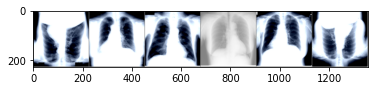

Real labels:  benign malignant benign non-nodule malignant malignant
Predicted:  malignant benign malignant non-nodule benign malignant


In [ ]:
testBatch()

# **PLOT ACCURACY**

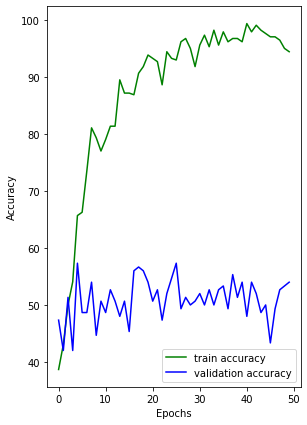

In [ ]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('../outputs/plots/accuracy.png')


# **PLOT LOSS**

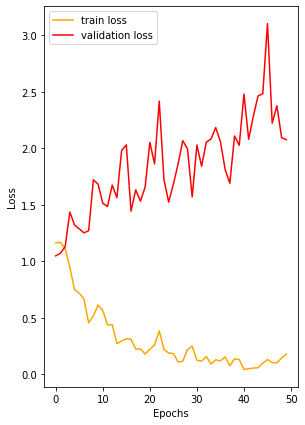

In [ ]:
# loss plots
plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('../outputs/plots/loss.png')
plt.show()

In [ ]:
label2class ={ 1 :'benign', 2 :'malignant', 3:'non-nodule'}

In [ ]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for batch,(inputs, labels) in enumerate(testLoader):
    
    
        inputs= inputs.to(device)
        labels= labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        
        

report = classification_report(y_true, y_pred)
print(report)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


              precision    recall  f1-score   support

           0       0.28      0.24      0.25        34
           1       0.56      0.50      0.53        66
           2       0.60      0.74      0.66        50

    accuracy                           0.52       150
   macro avg       0.48      0.49      0.48       150
weighted avg       0.51      0.52      0.51       150



Text(0.5, 42.0, 'Predicted label')

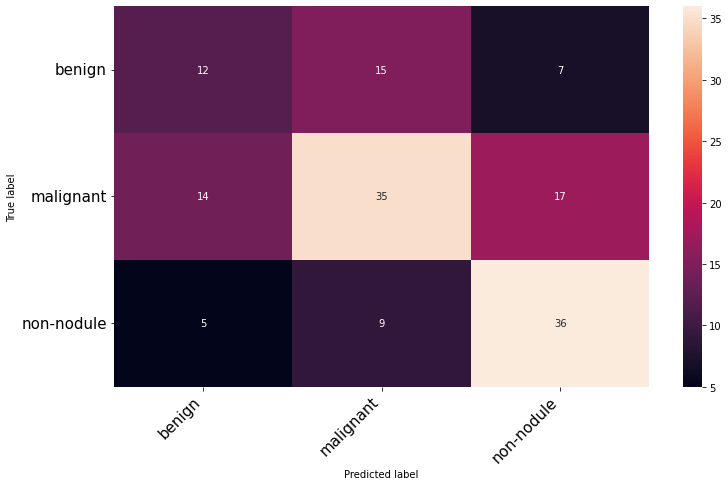

In [ ]:
nb_classes = 3
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testLoader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(12,7))

class_names = list(label2class.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')